In [59]:
%matplotlib inline

In [2]:
# this is my own procedure to set up plotting environment; just ignore it or replace if for your own
from pyathena.set_plt import *

ImportError: No module named set_plt

### Gravitational Potential

In [39]:
# new model
import astropy.constants as c
import astropy.units as u
import numpy as np

class gravpot(object):
    def __init__(self,param={}):
        self.surf_s=param['surf_star']*c.M_sun/c.pc**2
        self.rho_dm=(param['rho_dm']+param['rho_bulge'])*c.M_sun/c.pc**3
        self.z0=param['H_star']*c.kpc
        self.R0=param['radius']*c.kpc
        self.z=np.arange(0,3584,4)*u.pc
        self.phi=self.phi_ext(self.z)
    
    def g_star(self,z):
        g=2*np.pi*c.G*self.surf_s*z/np.sqrt(z**2+self.z0**2)
        return g.to('km/s**2')
    
    def g_dm(self,z):
        g=4*np.pi*c.G*self.rho_dm*z/(1+(z/self.R0)**2)#*u.M_sun/c.pc**2
        return g.to('km/s**2')
        
    def phi_star(self,z):
        phi=2*np.pi*c.G*(self.surf_s*(np.sqrt(z**2+self.z0**2)-self.z0))
        return phi.to('km**2/s**2')
    
    def phi_dm(self,z):
        phi=2*np.pi*c.G*self.rho_dm*self.R0**2*np.log(1+z**2/self.R0**2)
        return phi.to('km**2/s**2')
    
    def phi_ext(self,z):
        return self.phi_star(z)+self.phi_dm(z)
    
    def vesc(self,z):
        return np.sqrt(2*(self.phiext(z).to('km^2/s^2')))
    
    def phi_sg(self,z,surfg,zg):
        #phi=2*np.pi*c.G*surf_g*np.abs(z)#(np.sqrt(z**2+zg**2)-zg)
        
        phi=np.log(np.cosh((z/(zg*u.pc)).cgs.value))*2*np.pi*c.G*surfg*c.M_sun/c.pc**2*zg*u.pc
        return phi.to('km**2/s**2')

In [40]:
param={}
#surf_g = 9*c.M_sun/c.pc**2
param['surf_star']=42
param['rho_dm']=0.0064
param['H_star']=0.245
param['radius']=8.
param['rho_bulge']=0.0
print param
print surf_g

{'rho_bulge': 0.0, 'radius': 8.0, 'H_star': 0.245, 'surf_star': 42, 'rho_dm': 0.0064}
0.0187958359101 kg / m2


In [41]:
gpot=gravpot(param)
#print ((gpot.phi_ext(4584*u.pc)-gpot.phi_ext(3584*u.pc))*2)**0.5
#print gpot.g_star(gpot.z)
#print gpot.g_dm(gpot.z)
a = (gpot.g_star(gpot.z) + gpot.g_dm(gpot.z))
b = (gpot.phi_star(gpot.z) + gpot.phi_dm(gpot.z))[-1]
kb = 1.38064852*1e-16 # m^2 g s-2 K-1
print a
print b

print (a.cgs*surf_g.cgs/kb)


[  0.00000000e+00   6.45287909e-16   1.29009601e-15   1.93394640e-15
   2.57636500e-15   3.21688339e-15   3.85504064e-15   4.49038504e-15
   5.12247575e-15   5.75088438e-15   6.37519643e-15   6.99501260e-15
   7.60995007e-15   8.21964346e-15   8.82374585e-15   9.42192955e-15
   1.00138867e-14   1.05993299e-14   1.11779922e-14   1.17496281e-14
   1.23140125e-14   1.28709420e-14   1.34202335e-14   1.39617248e-14
   1.44952738e-14   1.50207583e-14   1.55380754e-14   1.60471408e-14
   1.65478880e-14   1.70402680e-14   1.75242482e-14   1.79998119e-14
   1.84669569e-14   1.89256955e-14   1.93760527e-14   1.98180664e-14
   2.02517854e-14   2.06772696e-14   2.10945885e-14   2.15038206e-14
   2.19050526e-14   2.22983788e-14   2.26839001e-14   2.30617233e-14
   2.34319606e-14   2.37947289e-14   2.41501491e-14   2.44983456e-14
   2.48394459e-14   2.51735795e-14   2.55008783e-14   2.58214754e-14
   2.61355052e-14   2.64431024e-14   2.67444026e-14   2.70395410e-14
   2.73286527e-14   2.76118721e-14

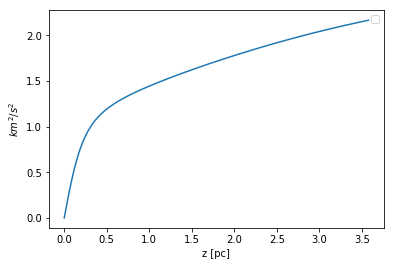

In [45]:
import matplotlib.pyplot as plt
#plt.plot(gpot.z,gpot.phi,label='1')
plt.plot(gpot.z/1000.,a/(3.24*1e-14))
#plt.plot(gpot.phi_ext(gpot.z),gpot.z,label='DM+Star')
#plt.plot(gpot.phi_dm(gpot.z),gpot.z,label='DM')
#plt.plot(gpot.phi_star(gpot.z),gpot.z,label='star')
#plt.plot(gpot.phi_sg(gpot.z,42,500),gpot.z,label='5')
plt.legend()
plt.ylabel(r'$km^2$/$s^2$')
plt.xlabel('z [pc]')
#plt.savefig('gravity.png')
plt.show()

### Part I: calculate ballistic estimation from an example distribution

In [65]:
def get_ballistic_dist(gpot,v,dMdv,zi,zf):
    v_Dphi=np.sqrt(2.0*(gpot.phi_ext(zf)-gpot.phi_ext(zi))).value
    v_Dphi_max=np.sqrt(2.0*(gpot.phi[-1]-gpot.phi_ext(zi))).value
    ipos=v>=v_Dphi
    vfpos=np.sqrt(v[ipos]**2-v_Dphi**2)
    dMdvfpos=dMdv[ipos]
    ineg=(v>=v_Dphi) & (v<v_Dphi_max)
    vfneg=np.sqrt(v[ineg]**2-v_Dphi**2)
    dMdvfneg=dMdv[ineg]

    vf=np.append(-vfneg[::-1],vfpos)
    dMdvf=np.append(dMdvfneg[::-1],dMdvfpos)
    
    return vf,dMdvf

In [66]:
Mtot=10.
sigma=20.
v=np.arange(-200,201,0.1)
dMdv=Mtot/np.sqrt(2*np.pi*sigma**2)*np.exp(-v**2/2/sigma**2)
dMdv=Mtot/(2*sigma)*np.exp(-np.abs(v)/sigma)

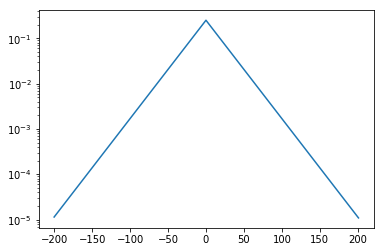

In [67]:
plt.semilogy(v,dMdv)
plt.show()

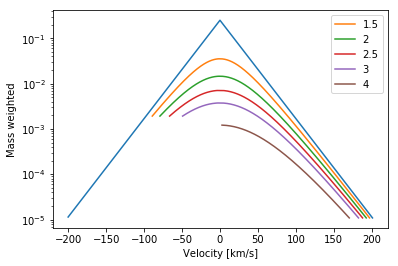

In [68]:
zi=1*u.kpc
plt.semilogy(v,dMdv)
for zf in [1.5,2,2.5,3,4]:
    vf,dMdvf=get_ballistic_dist(gpot,v,dMdv,zi,zf*u.kpc)
    plt.plot(vf,dMdvf,label=zf)
plt.legend()
plt.xlabel('Velocity [km/s]')
plt.ylabel('Mass weighted')
#plt.savefig('model.png')
plt.show()


### Part II: calculate ballistic estimation using simulation outcomes

In [69]:
import pandas as pd

In [108]:
import glob
import cPickle
labell = (r'No ICM','ICM00','ICM0','ICM1','ICM2','ICM3','ICM4') # 'NonICM',r'No ICM',
labelll = ('Total','Cold&Warm','Hot')
k = 4

In [109]:
# I have my own way of calculating and storing the mass-weigthed PDF as a function of v and z
# Please modify the code to make it work with your data format
wpdf_files=cPickle.load(open('F:/yeongu/surf_ism_cold_%s.pkl' % labell[k],'rb'))#glob.glob('/Users/ckim/Research/TIGRESS/MHD_4pc_new/vel_pdf/*.w.mpdf')
ipdf_files=cPickle.load(open('F:/yeongu/surf_ism_ion_%s.pkl' % labell[k],'rb'))#glob.glob('/Users/ckim/Research/TIGRESS/MHD_4pc_new/vel_pdf/*.i.mpdf')
hpdf_files=cPickle.load(open('F:/yeongu/surf_ism_hot_%s.pkl' % labell[k],'rb'))#glob.glob('/Users/ckim/Research/TIGRESS/MHD_4pc_new/vel_pdf/*.h.mpdf')

In [110]:
print wpdf_files.shape

(250L, 896L, 399L)


In [111]:
def get_mpdf_mean(pdf_files):
    mpdf=pdf_files.mean(axis=0)
    mpdf=np.mean(pdf_files,axis=0)
    print mpdf.shape
    return mpdf

In [112]:
def get_dist_from_tigress(mpdf,z0,dz):
    z=np.arange(0,896)
    zidxpos= (z > (z0-dz)) & (z < (z0+dz))
    zidxneg= (z < 896 -(z0-dz)) & (z > 896 -(z0+dz)) 
    #print zidxpos
    mpdf_pos=mpdf[zidxpos].mean(axis=0)
    mpdf_neg=mpdf[zidxneg].mean(axis=0)
    mpdf_neg = mpdf_neg[::-1]
    #mpdf_z = mpdf_neg
    #mpdf_z = mpdf_pos
    mpdf_z=0.5*(mpdf_pos+mpdf_neg)
    
    return mpdf_z

In [113]:
mpdf=[]
for pdf_files in [wpdf_files,ipdf_files,hpdf_files]:
    mpdf.append(get_mpdf_mean(pdf_files))

(896L, 399L)
(896L, 399L)
(896L, 399L)


In [114]:
###### Not Cummulative #####
def plot_ballistic(mpdf,zlist=[1,2,3]):
    dMdv=None
    plt.figure(figsize=(12,4))
    for i,z0 in enumerate(zlist):
        mpdf_z=get_dist_from_tigress(mpdf,int((z0*125)+448),dz=4)
        if dMdv is None:            
            Mtot=mpdf_z.sum()
            vi=np.arange(-995,1000,5)
            dMdv=mpdf_z
            zi=z0*u.kpc
            vf=vi
            dMdvf=dMdv
            v2=vi[(dMdv/Mtot)>1.e-6].max()
            v1=-v2
        else:
            zf=z0*u.kpc
            vf,dMdvf=get_ballistic_dist(gpot,vi,dMdv,zi,zf)
        plt.subplot(1,3,i+1)
        plt.title('%s kpc' % zlist[i])
        #plt.semilogy(vi,(mpdf_z/Mtot).cumsum()[::-1],label=r'$f_f(v)$',marker='o',markersize=2,color='r')
        plt.semilogy(vi,(mpdf_z/Mtot),label=r'$f_f(v)$ (Data)',marker='o',markersize=2,color='r')
        plt.semilogy(vf,dMdvf/Mtot,label=r'$f^b_f(v)$ (Calculation)',marker='o',markersize=2,color='b')
        plt.semilogy(vi,dMdv/Mtot,label=r'$f_i(v)$ (Reference)',marker='o',markersize=2,color='k')
        #plt.axvline(0)
        plt.xlabel('Velocity [km/s]')
         
        plt.ylim(1.e-5,1)
        plt.xlim(v1*0.5,v2)
        
        #plt.legend()
        if i == 0: plt.legend()
    plt.tight_layout()
    

ICM2


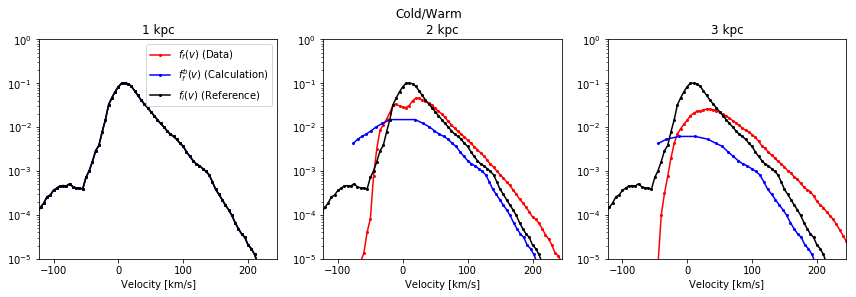

In [115]:
j=0
plot_ballistic(mpdf[j])
plt.suptitle('Cold/Warm',y=1.02)
plt.savefig('D:/yeongu/plots/vel_test/%s_cold_talk.png' % labell[k],dpi=200)
#plt.savefig('testttt.png',dpi=500)
print labell[k]
plt.show()

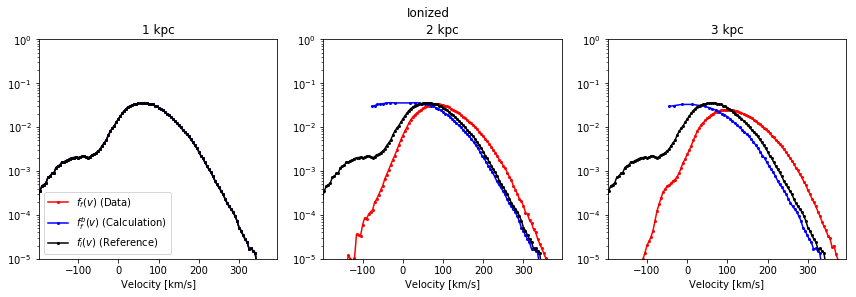

In [116]:
j=1
plot_ballistic(mpdf[j])
plt.suptitle('Ionized',y=1.02)
plt.savefig('D:/yeongu/plots/vel_test/%s_ion_talk.png' % labell[k],dpi=200)
plt.show()

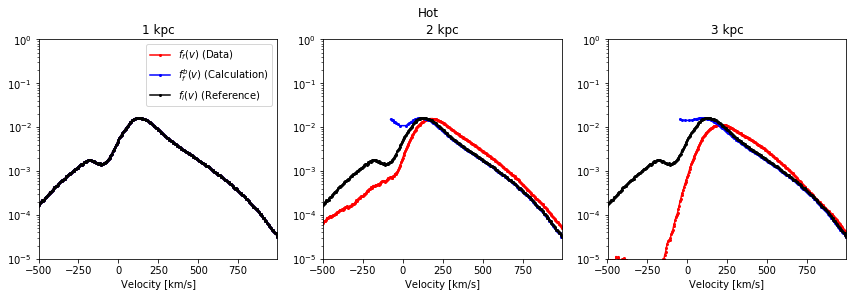

In [117]:
j=2
plot_ballistic(mpdf[j])
plt.suptitle('Hot',y=1.02)
plt.savefig('D:/yeongu/plots/vel_test/%s_hot_talk.png' % labell[k],dpi=200)
plt.show()

In [ ]:
##### Cumulative #####
from scipy import interpolate

def plot_ballistic(mpdf,zlist=[1,1.5,2,2.5,3,3.5]):
    dMdv=None
    plt.figure(figsize=(12,8))
    for i,z0 in enumerate(zlist):
        mpdf_z=get_dist_from_tigress(mpdf,int((z0*125)+448),dz=3)
        if dMdv is None:            
            Mtot=mpdf_z.sum()
            vi=np.arange(-995,1000,5)
            dMdv=mpdf_z
            zi=z0*u.kpc
            vf=vi
            dMdvf=dMdv
            v2=vi[(dMdv/Mtot)>1.e-6].max()
            v1=-v2
        else:
            zf=z0*u.kpc
            vf,dMdvf=get_ballistic_dist(gpot,vi,dMdv,zi,zf)
        plt.subplot(2,3,i+1)
        plt.title('%s kpc' % zlist[i])
        #plt.semilogy(vi,(mpdf_z/Mtot).cumsum()[::-1],label=r'$f_f(v)$',marker='o',markersize=2,color='r')
        f = interpolate.interp1d(vf,(dMdvf/Mtot),fill_value='extrapolate')
        ynew = f(vi)
        #print ynew
        plt.semilogy(-vi,(mpdf_z/Mtot)[::-1].cumsum(),label=r'$f_f(v)$ (Data)',marker='o',markersize=2,color='r')
        plt.semilogy(vf[::-1],(dMdvf/Mtot)[::-1].cumsum(),label=r'$f^b_f(v)$ (Calculation)',marker='o',markersize=2,color='b')
        #print vf
        #plt.semilogy(vi,ynew,label=r'$f^b_f(v)$ (Calculation)',marker='o',markersize=2,color='b',alpha=0.5)
        plt.semilogy(-vi,(dMdv/Mtot)[::-1].cumsum(),label=r'$f_i(v)$ (Reference)',marker='o',markersize=2,color='k')
        #plt.axvline(0)
        plt.xlabel('Velocity [km/s]')
         
        #plt.ylim(1.e-4,2)
        #plt.xlim(v1,v2)
        if j==0:
            plt.xlim(-200,200)
            plt.ylim(1.e-6,2)
        if j==1:
            plt.xlim(-300,300)
            plt.ylim(1.e-5,2)
        if j==2:
            plt.xlim(-500,500)
            plt.ylim(1.e-4,2)
        #print vi
        #print vf.shape
        #plt.legend()
        if i == 0: plt.legend()
    plt.tight_layout()

    #print ynew